# Pre-trained

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models.video import s3d
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import torch
from torchvision import transforms
from PIL import Image
import datetime as dt
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import pandas as pd

In [4]:
# Function to load video frames without transformations
def load_video_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    success, frame = cap.read()
    while success:
        # Convert BGR (OpenCV format) to RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # Convert NumPy array to PIL image
        frames.append(Image.fromarray(frame))
        success, frame = cap.read()
    cap.release()
    return frames  # Return the list of PIL images


# Save pretrained model
def save_pretrained(model):
    date_time_format = '%Y-%m-%d-%H-%M-%S'
    current_date_time_dt = dt.datetime.now()
    current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
    model_name = f'{current_date_time_string}-pretrained-model.pt'
    save_path = f'../models/pretrained/{model_name}'

    torch.save(model.state_dict(), save_path)

    print(f"Saved model to {save_path}")


# Load pretrained model 
def load_pretrained(model, model_path, check_weights=False):
    trained_model = model.load_state_dict(torch.load(model_path, weights_only=False))

    print(f'Loaded model from {model_path}')

    # Check weights
    if check_weights:
        for var_name in model.state_dict():
            print(var_name, "\t", model.state_dict()[var_name])

    return trained_model


# Function to train the model
def train_model(device, model, train_loader, criterion, optimizer, num_epochs=5):
    trained_model = model.train()
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        print("")
        print("Training")
        print("")
        
        count = 1

        for videos, labels in train_loader:
            print(f'{count}/{len(train_loader)}')
            videos, labels = videos.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(videos)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            count += 1

        count = 1
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}, Accuracy: {100 * correct / total}%")

    save_pretrained(trained_model)


# Function to test the model and return predictions and true labels
def evaluate_model(device, model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    count = 1
    with torch.no_grad():
        for videos, labels in loader:
            print(f'{count}/{len(loader)}')
            videos, labels = videos.to(device), labels.to(device)
            outputs = model(videos)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            count += 1
        count = 1
    return np.array(all_preds), np.array(all_labels)


# Function to plot confusion matrix
def plot_confusion_matrix(true_labels, preds, classes):
    cm = confusion_matrix(true_labels, preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

# Function to plot confusion matrix. This prevents notebooks from printing the plot twice.
def plot_confusion(t_class, p_class, title, cmap='turbo', **kwargs):

    # Define plot design
    title = title
    title_size = 'xx-large'
    label_size = 'large'
    tick_size = 'small'
    colors = cmap
    padding = 14

    if 'display_labels' in kwargs:
        d_labels = kwargs.get("display_labels")

    fig, ax = plt.subplots(figsize=(8,6))

    # plt.suptitle(title, fontsize = title_size)
    plt.title(title, fontsize = title_size, pad=padding * 1.25)
    plt.xticks(fontsize = tick_size)
    plt.yticks(fontsize = tick_size)
    plt.ylabel("True label", fontsize = label_size, labelpad=padding)
    plt.xlabel("Predicted label", fontsize = label_size, labelpad=padding)
    plt.subplots_adjust(bottom=0.35)

    if 'display_labels' in kwargs:
        d_labels = kwargs.get("display_labels")
        cm = ConfusionMatrixDisplay.from_predictions(t_class, p_class, cmap=colors, display_labels=d_labels)
    else:
        cm = ConfusionMatrixDisplay.from_predictions(t_class, p_class, cmap=colors)

    report = classification_report(t_class, p_class)
    print(report)

    cm.plot(ax=ax, 
            xticks_rotation='vertical', 
            cmap=colors)
    
    plt.close()

    return fig



In [5]:
max_frames = 100  # Set your desired fixed number of frames

class CustomVideoDataset(datasets.DatasetFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        frames = self.loader(path)  # Load frames as PIL images
        frames = [transform(frame) for frame in frames]  # Apply transformations here

        # Limit to max_frames
        if len(frames) > max_frames:
            frames = frames[:max_frames]
        else:
            # If there are fewer frames, pad with zeros
            frames += [torch.zeros_like(frames[0])] * (max_frames - len(frames))

        # Stack the frames
        video_tensor = torch.stack(frames)


        video_tensor = video_tensor.permute(1, 0, 2, 3)
        video_tensor = video_tensor.unsqueeze(0)

        return video_tensor.squeeze(0), target


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define transformations for video frames
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Using device: cpu


In [6]:
# Load train and test datasets using DatasetFolder
train_dir = '../downloads/train'
test_dir = '../downloads/test'

train_dataset = CustomVideoDataset(root=train_dir, loader=load_video_frames, extensions=('mp4',))
test_dataset = CustomVideoDataset(root=test_dir, loader=load_video_frames, extensions=('mp4',))

# Create data loaders as before
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Load pre-trained S3D model and modify the classifier
# model = s3d(pretrained=True)
model = s3d(weights='KINETICS400_V1')
# Access the classifier layers
dropout = model.classifier[0]  # Keep the dropout layer
num_ftrs = model.classifier[1].in_channels  # Get the number of input channels to the Conv3d layer

# Replace the last Conv3d layer with a new one that has the correct number of output classes
model.classifier = nn.Sequential(
    dropout,
    nn.Conv3d(num_ftrs, len(train_dataset.classes), kernel_size=(1, 1, 1))  # Modify for dataset's number of classes
)

model = model.to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

5 epochs on 9/30/2024  
Training time = 1146m 4.0s (19 hours)

10 epochs on 10/3/2024  
Training time = 1398m, 5.5s (23.3 hours)

In [6]:
# Train the model
train_model(device, model, train_loader, criterion, optimizer, num_epochs=10)


Training

1/112
2/112
3/112
4/112
5/112
6/112
7/112
8/112
9/112
10/112
11/112
12/112
13/112
14/112
15/112
16/112
17/112
18/112
19/112
20/112
21/112
22/112
23/112
24/112
25/112
26/112
27/112
28/112
29/112
30/112
31/112
32/112
33/112
34/112
35/112
36/112
37/112
38/112
39/112
40/112
41/112
42/112
43/112
44/112
45/112
46/112
47/112
48/112
49/112
50/112
51/112
52/112
53/112
54/112
55/112
56/112
57/112
58/112
59/112
60/112
61/112
62/112
63/112
64/112
65/112
66/112
67/112
68/112
69/112
70/112
71/112
72/112
73/112
74/112
75/112
76/112
77/112
78/112
79/112
80/112
81/112
82/112
83/112
84/112
85/112
86/112
87/112
88/112
89/112
90/112
91/112
92/112
93/112
94/112
95/112
96/112
97/112
98/112
99/112
100/112
101/112
102/112
103/112
104/112
105/112
106/112
107/112
108/112
109/112
110/112
111/112
112/112
Epoch [1/10], Loss: 1.6210459827312402, Accuracy: 47.32142857142857%

Training

1/112
2/112
3/112
4/112
5/112
6/112
7/112
8/112
9/112
10/112
11/112
12/112
13/112
14/112
15/112
16/112
17/112
18/112
19/1

In [8]:
# Load model
model_dir = '../models/pretrained'
model_name = '2024-10-03-14-33-46-pretrained-model.pt'
model_path = f'{model_dir}/{model_name}'
load_pretrained(model, model_path)

UnpicklingError: Weights only load failed. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution.Do it only if you get the file from a trusted source. WeightsUnpickler error: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

## Evaluate on testing data

Run time = 150m 40.3s (~2.5 hrs)

In [7]:
# Evaluate on testing data
test_preds, test_labels = evaluate_model(device, model, test_loader)  # Add some printouts to see status

1/112
2/112
3/112
4/112
5/112
6/112
7/112
8/112
9/112
10/112
11/112
12/112
13/112
14/112
15/112
16/112
17/112
18/112
19/112
20/112
21/112
22/112
23/112
24/112
25/112
26/112
27/112
28/112
29/112
30/112
31/112
32/112
33/112
34/112
35/112
36/112
37/112
38/112
39/112
40/112
41/112
42/112
43/112
44/112
45/112
46/112
47/112
48/112
49/112
50/112
51/112
52/112
53/112
54/112
55/112
56/112
57/112
58/112
59/112
60/112
61/112
62/112
63/112
64/112
65/112
66/112
67/112
68/112
69/112
70/112
71/112
72/112
73/112
74/112
75/112
76/112
77/112
78/112
79/112
80/112
81/112
82/112
83/112
84/112
85/112
86/112
87/112
88/112
89/112
90/112
91/112
92/112
93/112
94/112
95/112
96/112
97/112
98/112
99/112
100/112
101/112
102/112
103/112
104/112
105/112
106/112
107/112
108/112
109/112
110/112
111/112
112/112


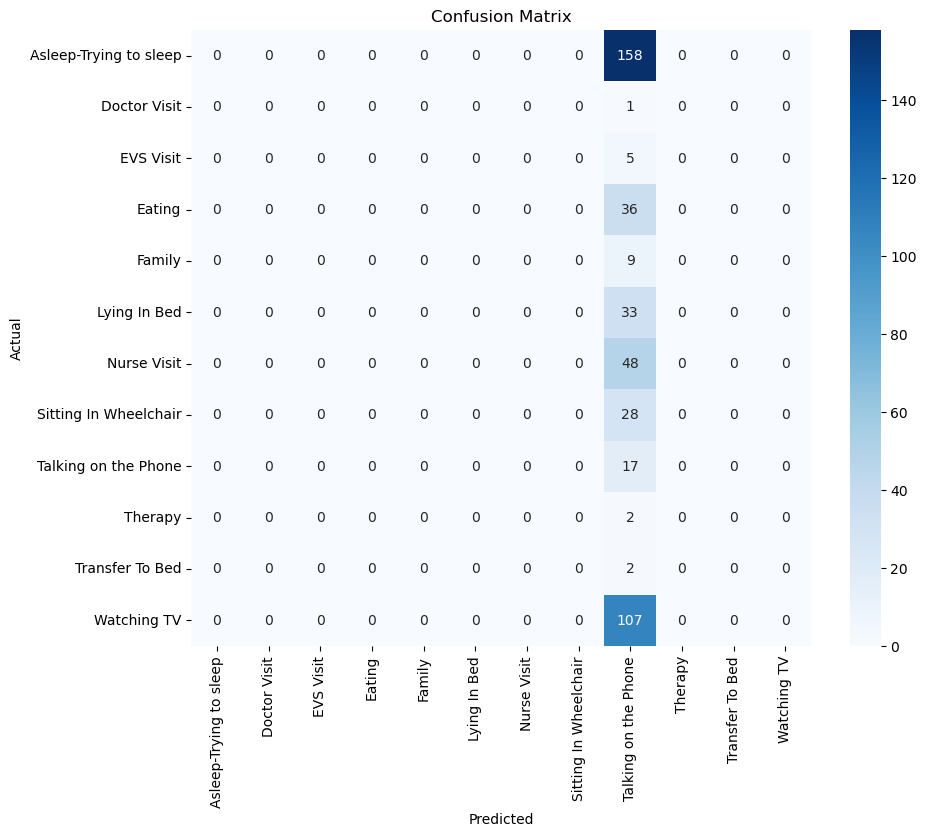

In [8]:
plot_confusion_matrix(test_labels, test_preds, test_dataset.classes)

c:\Users\james\.conda\envs\nmda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\james\.conda\envs\nmda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\james\.conda\envs\nmda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       158
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00        36
           4       0.00      0.00      0.00         9
           5       0.00      0.00      0.00        33
           6       0.00      0.00      0.00        48
           7       0.00      0.00      0.00        28
           8       0.04      1.00      0.07        17
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00       107

    accuracy                           0.04       446
   macro avg       0.00      0.08      0.01       446
weighted avg       0.00      0.04      0.00       446



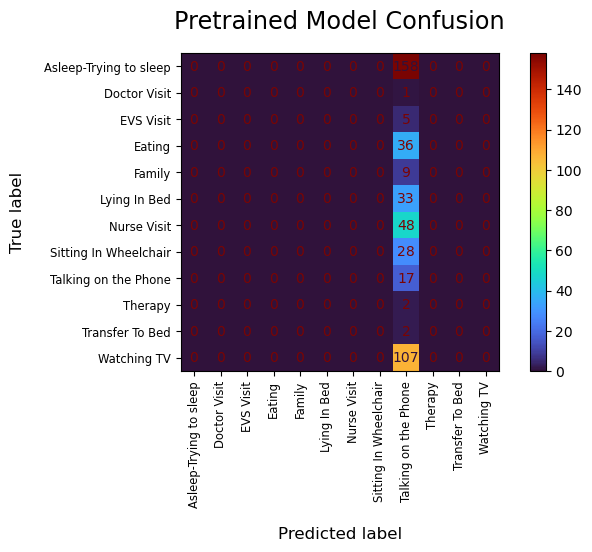

In [9]:
pretrained_confusion = plot_confusion(t_class = test_labels, 
                                      p_class = test_preds, 
                                      title = "Pretrained Model Confusion", 
                                    #   cmap = "Blues", 
                                      cmap = "turbo",
                                      display_labels=test_dataset.classes)
plt.show()

#### No need to plot confusion for training data

In [8]:
# Evaluate on training data
# train_preds, train_labels = evaluate_model(device, model, train_loader)

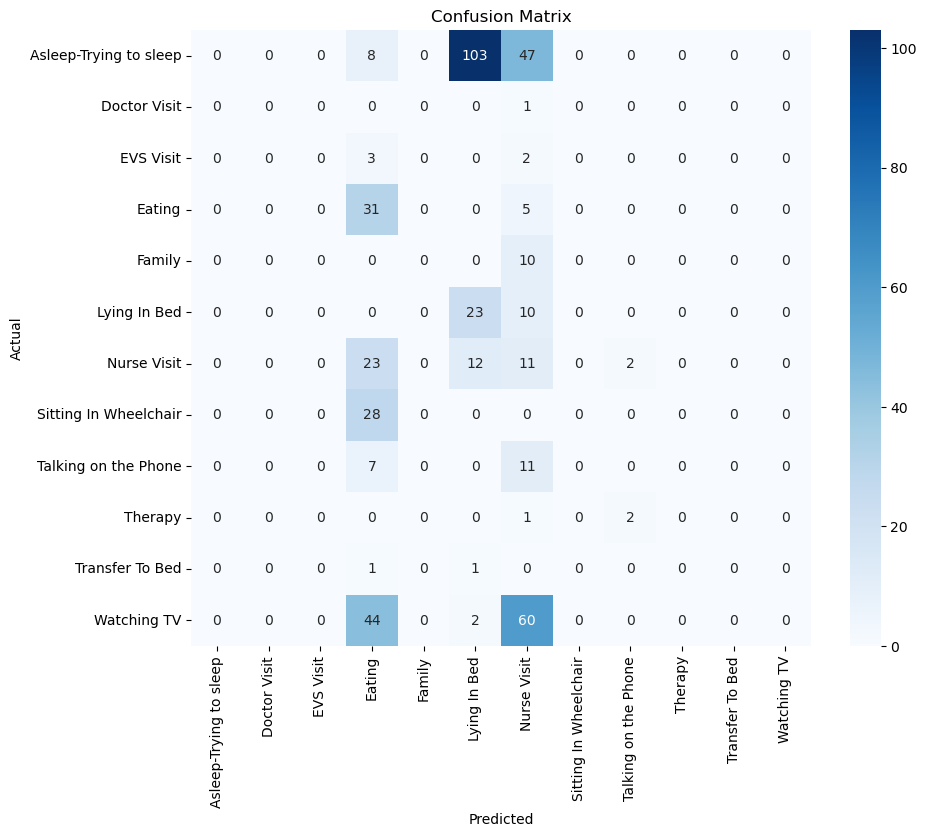

In [9]:
# Plot confusion matrix
# plot_confusion_matrix(train_labels, train_preds, train_dataset.classes)